# Jupyter notebook for debugging

In [2]:
%load_ext autoreload
%autoreload 2

# Copied from `train` function in train_simple.py:L78
import yaml

device = 'cpu'
hyp = 'data/hyps/hyp.scratch-low.yaml'

with open(hyp, errors="ignore") as f:
    hyp = yaml.safe_load(f)  # load hyps dict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
from models.yolo import Model
from utils.general import check_dataset

cfg = 'models/yolov5n_kaist-rgbt.yaml'
data = 'data/kaist-rgbt.yaml'
data_dict = check_dataset(data)

nc = int(data_dict["nc"])  # number of classes
model = Model(cfg, ch=3, nc=nc, anchors=hyp.get("anchors")).to(device)  # create

Overriding model.yaml nc=1 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.MultiStreamConv           [3, 16, 6, 2, 2]              
  1                -1  1      9344  models.common.MultiStreamConv           [16, 32, 3, 2]                
  2                -1  1      9600  models.common.MultiStreamC3             [32, 32, 1]                   
  3                -1  1         0  models.common.Fusion                    ['concat', 2]                 
  4                -1  1      4224  models.common.Conv                      [64, 64, 1, 1]                
  5                -1  1     36992  models.common.Conv                      [64, 64, 3, 2]                
  6                -1  2     29184  models.common.C3                        [64, 64, 2]                   
  7                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               

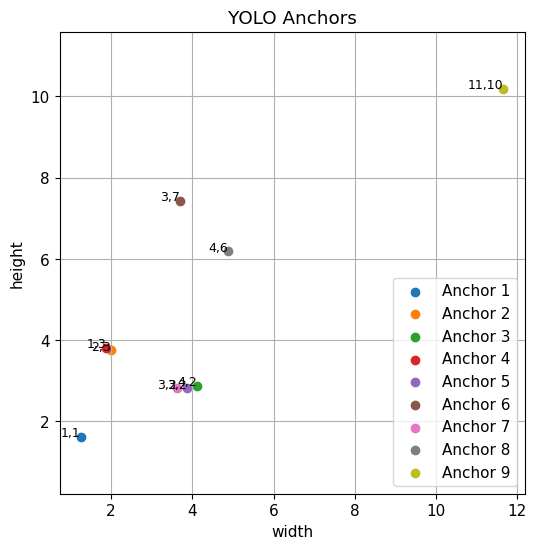

In [27]:
# 반드시 첫 셀 또는 해당 셀 상단에 추가
%matplotlib inline  

import matplotlib.pyplot as plt
import numpy as np
import torch

# anchors: Tensor (3, 3, 2) 형태일 것임 (layer 수, anchor 수, [w, h])
anchors = model.model[-1].anchors  # shape: torch.Size([3, 3, 2])

# Tensor → numpy 변환 (detach, cpu, numpy)
all_anchors = anchors.clone().detach().cpu().numpy().reshape(-1, 2)

# 시각화
plt.close('all')
plt.figure(figsize=(6, 6))
plt.title("YOLO Anchors")
plt.xlabel("width")
plt.ylabel("height")
plt.grid(True)

for i, (w, h) in enumerate(all_anchors):
    plt.scatter(w, h, label=f"Anchor {i+1}")
    plt.text(w, h, f"{int(w)},{int(h)}", fontsize=9, ha='right')

plt.legend()
plt.axis("equal")
plt.show()


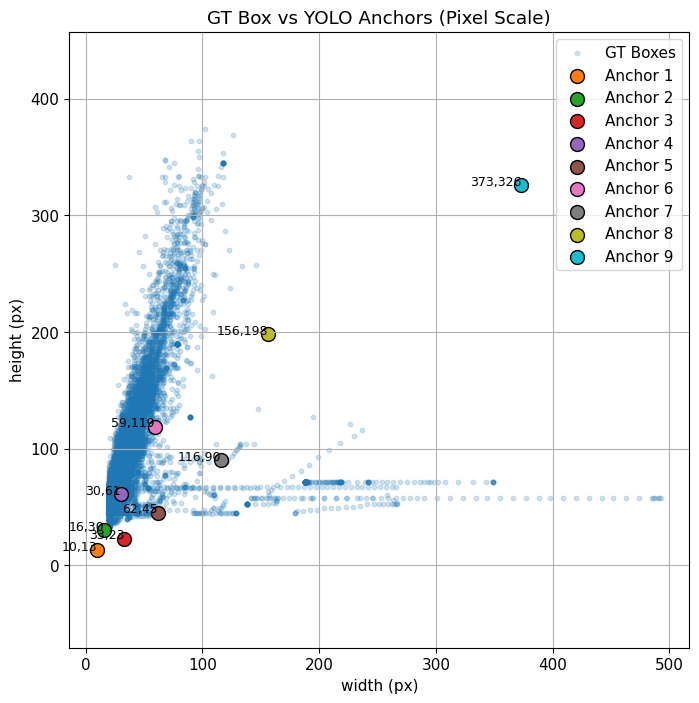

In [28]:
# 기존 anchor랑 GT 분포 비교
# Jupyter용 설정
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import torch
import glob
import os

# 1. Anchor 가져오기
anchors = model.model[-1].anchors  # shape: (3, 3, 2)
all_anchors = anchors.clone().detach().cpu().numpy().reshape(-1, 2)

# 2. stride 기준으로 pixel 단위 스케일 변환
strides = [8, 16, 32]
scaled_anchors = all_anchors.copy()
scaled_anchors[:3] *= strides[0]
scaled_anchors[3:6] *= strides[1]
scaled_anchors[6:9] *= strides[2]

# 3. GT label(.txt) 경로 설정
label_dir = 'datasets/kaist-rgbt/train/labels'  # ← 경로 수정 필요 시 변경
label_paths = glob.glob(os.path.join(label_dir, '*.txt'))

gt_widths = []
gt_heights = []

for path in label_paths:
    with open(path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) >= 6:
                ignore = int(parts[5])
                if ignore != 0:
                    continue  # ignore=1이면 건너뜀
                w = float(parts[3])
                h = float(parts[4])
                gt_widths.append(w)
                gt_heights.append(h)

# 4. GT 박스를 pixel 단위로 복원
img_size = 640  # input size
gt_widths_pixel = np.array(gt_widths) * img_size
gt_heights_pixel = np.array(gt_heights) * img_size

# 5. 시각화
plt.figure(figsize=(8, 8))
plt.scatter(gt_widths_pixel, gt_heights_pixel, alpha=0.2, s=10, label='GT Boxes')

for i, (w, h) in enumerate(scaled_anchors):
    plt.scatter(w, h, s=100, edgecolors='black', label=f"Anchor {i+1}")
    plt.text(w, h, f"{int(w)},{int(h)}", fontsize=9, ha='right')

plt.xlabel("width (px)")
plt.ylabel("height (px)")
plt.title("GT Box vs YOLO Anchors (Pixel Scale)")
plt.grid(True)
plt.legend()
plt.axis("equal")
plt.show()


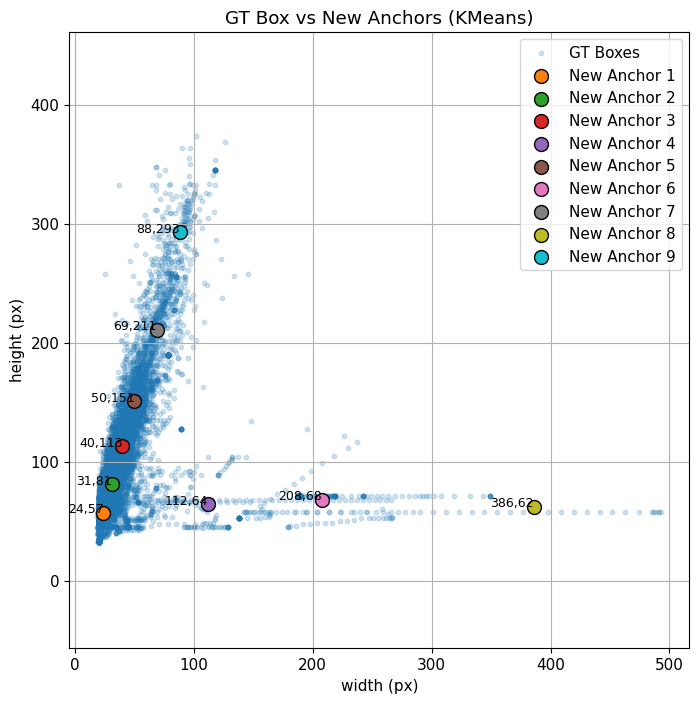

📦 New Anchors (pixel units):
[[24, 57], [31, 81], [40, 113], [112, 64], [50, 151], [208, 68], [69, 211], [386, 62], [88, 293]]


In [ ]:
# kmeans로 GT 분포를 통해 새로운 anchor 생성

from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

# 1. GT 박스 준비
# 기존 GT (pixel 단위)에서 width, height stack
boxes = np.stack([gt_widths_pixel, gt_heights_pixel], axis=1)

# 너무 작은 박스 필터링 (예: width or height < 2px)
boxes = boxes[(boxes >= 2).all(axis=1)]

# 2. KMeans로 anchor 추출
k = 9  # anchor 개수
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10).fit(boxes)
new_anchors = np.round(kmeans.cluster_centers_).astype(int)

# 3. anchor 크기 순 정렬 (작은 것 → 큰 것)
new_anchors = new_anchors[np.argsort(new_anchors.prod(axis=1))]

# 4. 시각화
plt.figure(figsize=(8, 8))
plt.scatter(gt_widths_pixel, gt_heights_pixel, alpha=0.2, s=10, label='GT Boxes')

for i, (w, h) in enumerate(new_anchors):
    plt.scatter(w, h, s=100, edgecolors='black', label=f"New Anchor {i+1}")
    plt.text(w, h, f"{w},{h}", fontsize=9, ha='right')

plt.xlabel("width (px)")
plt.ylabel("height (px)")
plt.title("GT Box vs New Anchors (KMeans)")
plt.grid(True)
plt.legend()
plt.axis("equal")
plt.show()

# 5. 출력 결과
print("📦 New Anchors (pixel units):")
print(new_anchors.tolist())


/tmp/ipykernel_1567/3129817176.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', k)


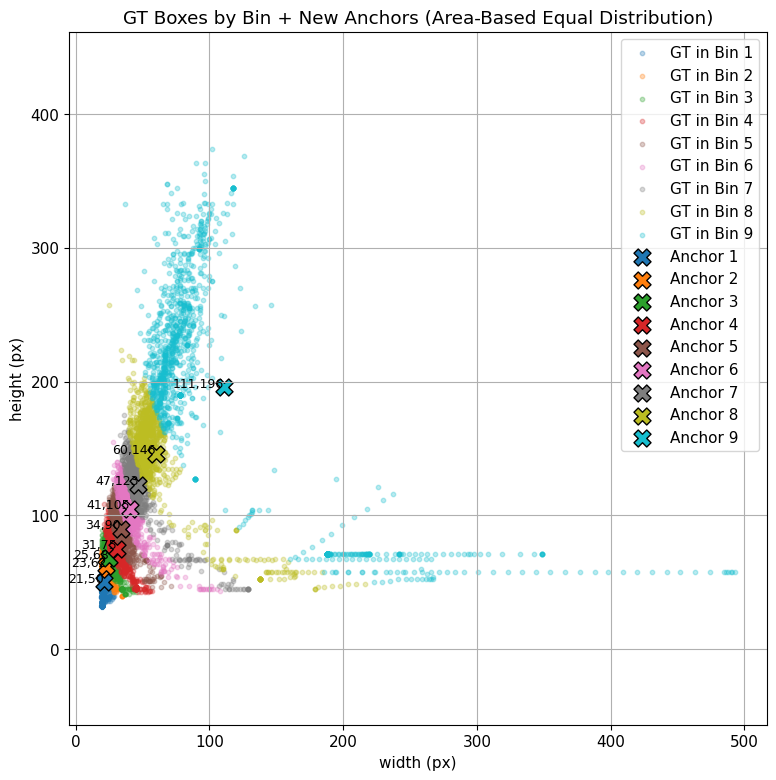

📦 New Anchors (pixel units):
[[21, 50], [23, 62], [25, 68], [31, 75], [34, 90], [41, 105], [47, 123], [60, 146], [111, 196]]

📊 GT 개수 per Anchor (클러스터 bin):
Anchor 1: GT count = 1213
Anchor 2: GT count = 1213
Anchor 3: GT count = 1213
Anchor 4: GT count = 1213
Anchor 5: GT count = 1213
Anchor 6: GT count = 1213
Anchor 7: GT count = 1213
Anchor 8: GT count = 1213
Anchor 9: GT count = 1212


In [21]:
# kmeans에서 각 클러스터별 GT 개수가 동일하도록 수정한 코드
import numpy as np
import matplotlib.pyplot as plt

# 1. GT 박스 준비
boxes = np.stack([gt_widths_pixel, gt_heights_pixel], axis=1)
boxes = boxes[(boxes >= 2).all(axis=1)]  # 너무 작은 박스 제거

# 2. 면적 기준 정렬 후 균등 분할
areas = boxes[:, 0] * boxes[:, 1]
sorted_indices = np.argsort(areas)
sorted_boxes = boxes[sorted_indices]

# 3. 균등하게 9개 bin으로 나누기
k = 9
bins = np.array_split(sorted_boxes, k)

# 4. 각 bin의 평균을 anchor로 사용
new_anchors = np.array([np.mean(b, axis=0) for b in bins])
new_anchors = np.round(new_anchors).astype(int)
new_anchors = new_anchors[np.argsort(new_anchors.prod(axis=1))]  # 면적 기준 정렬

# 5. 시각화 (클러스터 색상 구분)
plt.figure(figsize=(9, 9))
colors = plt.cm.get_cmap('tab10', k)

for i, b in enumerate(bins):
    plt.scatter(b[:, 0], b[:, 1], color=colors(i), alpha=0.3, s=10, label=f'GT in Bin {i+1}')

for i, (w, h) in enumerate(new_anchors):
    plt.scatter(w, h, s=150, edgecolors='black', color=colors(i), label=f"Anchor {i+1}", marker='X')
    plt.text(w, h, f"{w},{h}", fontsize=9, ha='right', color='black')

plt.xlabel("width (px)")
plt.ylabel("height (px)")
plt.title("GT Boxes by Bin + New Anchors (Area-Based Equal Distribution)")
plt.grid(True)
plt.legend()
plt.axis("equal")
plt.show()

# 6. 출력 결과
print("📦 New Anchors (pixel units):")
print(new_anchors.tolist())

print("\n📊 GT 개수 per Anchor (클러스터 bin):")
for i, b in enumerate(bins):
    print(f"Anchor {i+1}: GT count = {len(b)}")

/tmp/ipykernel_1567/2944837475.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', k)


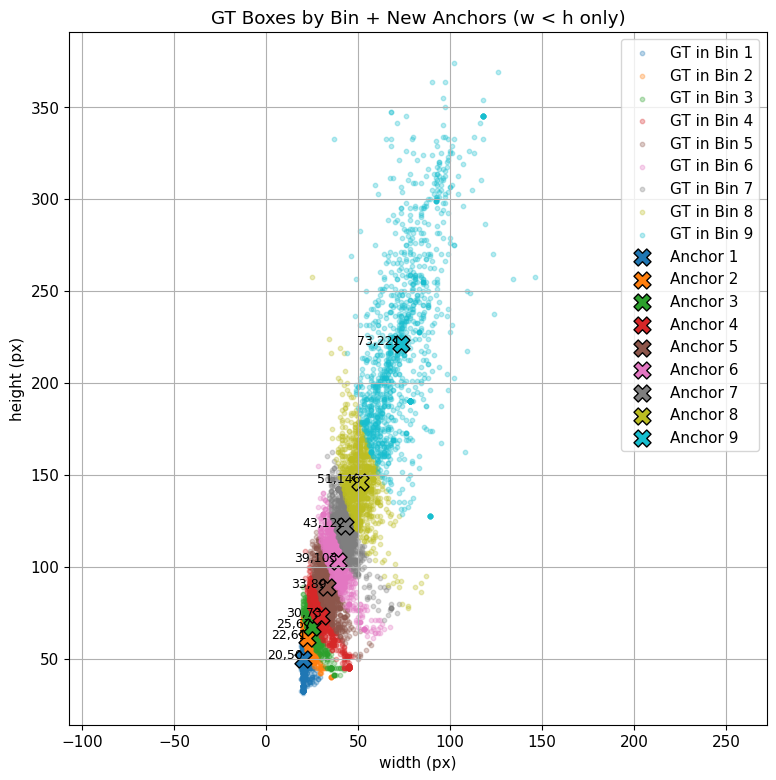

📦 New Anchors (pixel units):
[[20, 50], [22, 61], [25, 67], [30, 73], [33, 89], [39, 103], [43, 122], [51, 146], [73, 221]]

📊 GT 개수 per Anchor (클러스터 bin):
Anchor 1: GT count = 1155
Anchor 2: GT count = 1155
Anchor 3: GT count = 1155
Anchor 4: GT count = 1155
Anchor 5: GT count = 1155
Anchor 6: GT count = 1155
Anchor 7: GT count = 1155
Anchor 8: GT count = 1155
Anchor 9: GT count = 1154


In [25]:
# GT에서 width가 height보다 큰 데이터 제거 후 클러스터링
import numpy as np
import matplotlib.pyplot as plt

# 1. GT 박스 준비
boxes = np.stack([gt_widths_pixel, gt_heights_pixel], axis=1)
boxes = boxes[(boxes >= 2).all(axis=1)]  # 너무 작은 박스 제거

# 🔴 width > height인 박스 제거
boxes = boxes[boxes[:, 0] <= boxes[:, 1]]

# 2. 면적 기준 정렬 후 균등 분할
areas = boxes[:, 0] * boxes[:, 1]
sorted_indices = np.argsort(areas)
sorted_boxes = boxes[sorted_indices]

# 3. 균등하게 9개 bin으로 나누기
k = 9
bins = np.array_split(sorted_boxes, k)

# 4. 각 bin의 평균을 anchor로 사용
new_anchors = np.array([np.mean(b, axis=0) for b in bins])
new_anchors = np.round(new_anchors).astype(int)
new_anchors = new_anchors[np.argsort(new_anchors.prod(axis=1))]  # 면적 기준 정렬

# 5. 시각화 (클러스터 색상 구분)
plt.close('all')
plt.figure(figsize=(9, 9))
colors = plt.cm.get_cmap('tab10', k)

for i, b in enumerate(bins):
    plt.scatter(b[:, 0], b[:, 1], color=colors(i), alpha=0.3, s=10, label=f'GT in Bin {i+1}')

for i, (w, h) in enumerate(new_anchors):
    plt.scatter(w, h, s=150, edgecolors='black', color=colors(i), label=f"Anchor {i+1}", marker='X')
    plt.text(w, h, f"{w},{h}", fontsize=9, ha='right', color='black')

plt.xlabel("width (px)")
plt.ylabel("height (px)")

# ✅ 0,0 원점 맞춤
plt.xlim(left=0)
plt.ylim(bottom=0)

plt.title("GT Boxes by Bin + New Anchors (w < h only)")
plt.grid(True)
plt.legend()
plt.axis("equal")
plt.show()


# 6. 출력 결과
print("📦 New Anchors (pixel units):")
print(new_anchors.tolist())

print("\n📊 GT 개수 per Anchor (클러스터 bin):")
for i, b in enumerate(bins):
    print(f"Anchor {i+1}: GT count = {len(b)}")


## Sanity check: dataset
- Read images and label
- Visualize bounding boxes

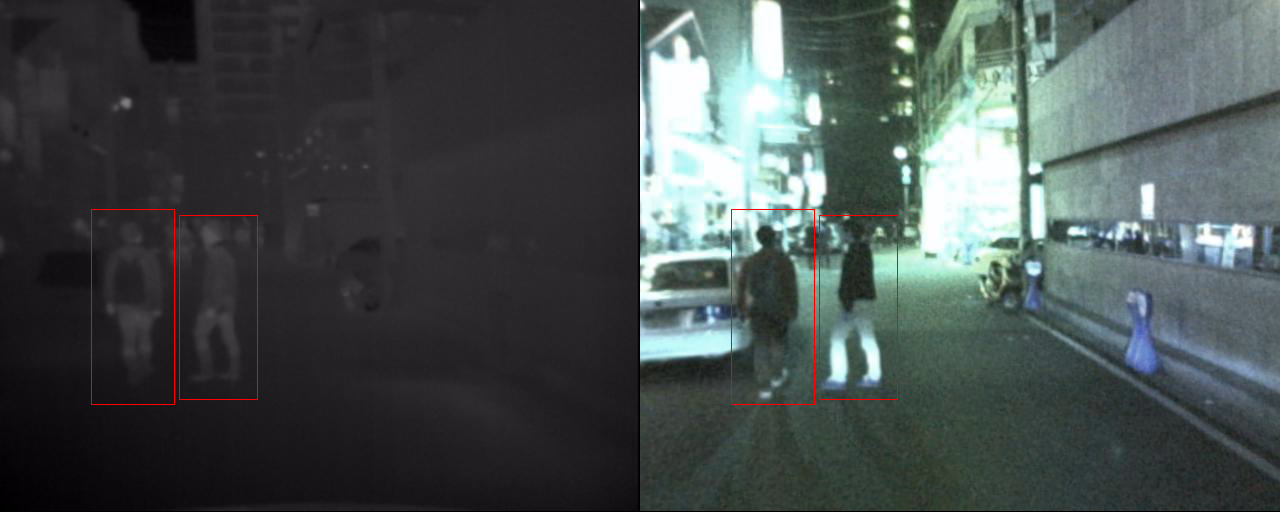

In [5]:
import cv2
import os
import numpy as np
from PIL import Image

annFile = 'datasets/kaist-rgbt/train/labels/set05_V000_I01219.txt'
lwirFile = annFile.replace('labels', 'images/lwir').replace('.txt', '.jpg')
visFile  = annFile.replace('labels', 'images/visible').replace('.txt', '.jpg')

# Read images
img_lwir = cv2.imread(lwirFile)
img_vis  = cv2.imread(visFile)

h, w = img_vis.shape[:2]

# Read labels
with open(annFile, 'r') as fp:
    labels = [x.split() for x in fp.read().strip().splitlines() if len(x)]

colors = {
    0: (255, 0, 0),
    1: (0, 255, 0),
    2: (0, 0, 255),
    3: (255, 0, 255),
}

if len(labels):
    # convert normalized bbox to pixel coordinates
    labels = np.array(labels, dtype=np.float32)
    labels[:, (1, 3)] *= w
    labels[:, (2, 4)] *= h

    cls = labels[:, 0]

    xyxy = np.zeros((len(labels), 4))
    xyxy[:, :2] = labels[:, 1:3]
    xyxy[:, 2:] = labels[:, 1:3] + labels[:, 3:5]
    xyxy = xyxy.astype(np.int16)

    for c, bb in zip(cls, xyxy):
        color = colors[c]
        cv2.rectangle(img_lwir, bb[:2], bb[2:], color)
        cv2.rectangle(img_vis,  bb[:2], bb[2:], color)

images = np.concatenate([img_lwir, img_vis], axis=1)
Image.fromarray(images)

## Sanity check: dataset class
- Visualize bounding boxes from dataset class

In [6]:
from utils.dataloaders import create_dataloader
from utils.general import check_img_size, colorstr

imgsz = 640
batch_size = 1
single_cls = False
seed = 0

train_path = data_dict["train"]
gs = max(int(model.stride.max()), 32)  # grid size (max stride)
imgsz = check_img_size(imgsz, gs, floor=gs * 2)  # verify imgsz is gs-multiple

train_loader, dataset = create_dataloader(
    train_path,
    imgsz,
    batch_size,
    gs,
    single_cls,
    hyp=hyp,
    augment=False,      # TODO: check if there is no bug when applying augmentation
    cache=None,
    rect=False,
    rank=-1,
    workers=8,
    image_weights=False,
    quad=False,
    prefix=colorstr("train: "),
    shuffle=False,      # No shuffle for debugging
    seed=seed,
    rgbt_input=True,
)


train: Scanning /workspaces/AUE8088/datasets/kaist-rgbt/train-all-04.cache... 12538 images, 7009 backgrounds, 0 corrupt: 100%|██████████| 12538/12538 [00:00<?, ?it/s]


datasets/kaist-rgbt/train/images/{}/set05_V000_I01219.jpg


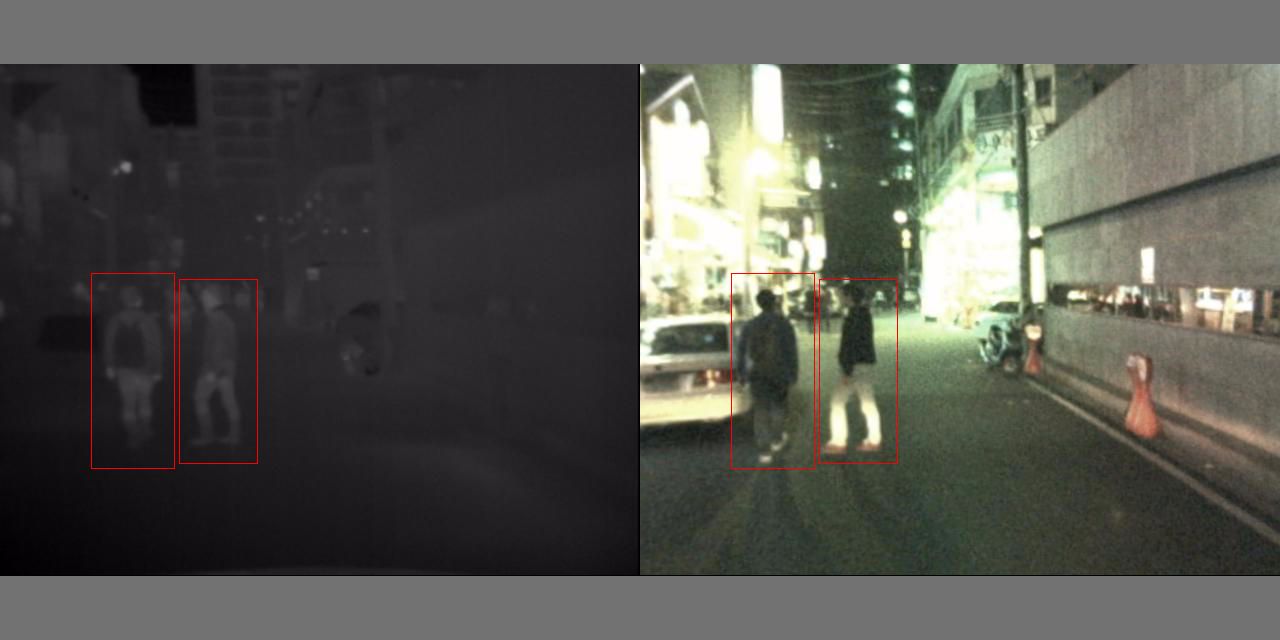

In [8]:
from utils.dataloaders import LoadRGBTImagesAndLabels
from utils.general import xywh2xyxy

frame = 12112

# Get a minibatch
# for ii, (imgs, targets, paths, _) in enumerate(train_loader):
#     break

# Get a minibatch (fast)
imgs, targets, paths, shapes, _ = LoadRGBTImagesAndLabels.collate_fn([dataset[frame]])

idx = 0
img_lwir = imgs[0][idx].numpy().transpose((1, 2, 0))
img_vis  = imgs[1][idx].numpy().transpose((1, 2, 0))
h, w = img_vis.shape[:2]

labels = targets.numpy()

colors = {
    0: (255, 0, 0),
    1: (0, 255, 0),
    2: (0, 0, 255),
    3: (255, 0, 255),
}

if len(labels):
    labels = labels[labels[:, 0] == idx, 1:]

    # convert normalized bbox to pixel coordinates
    labels = np.array(labels, dtype=np.float32)
    labels[:, (1, 3)] *= w
    labels[:, (2, 4)] *= h

    cls = labels[:, 0]

    xyxy = xywh2xyxy(labels[:, 1:5])
    xyxy = xyxy.astype(np.int16)

    img_lwir = np.ascontiguousarray(img_lwir)
    img_vis = np.ascontiguousarray(img_vis)

    for c, bb in zip(cls, xyxy):
        color = colors[c]
        cv2.rectangle(img_lwir, bb[:2], bb[2:], color)
        cv2.rectangle(img_vis,  bb[:2], bb[2:], color)

images = np.concatenate([img_lwir, img_vis], axis=1)
print(paths[idx])
Image.fromarray(images)

## Run trained model
- Visualize bounding boxes from dataset class

In [24]:
import torch
from models.yolo import Model
from utils.torch_utils import select_device

weights = 'kaist-rgbt_best.pt'      # Train your own model!
data = 'data/kaist-rgbt.yaml'
cfg = 'models/yolov5s_kaist-rgbt.yaml'
hyp = 'data/hyps/hyp.scratch-low.yaml'
nc = 1
half = False  # use FP16 half-precision inference
dnn = False  # use OpenCV DNN for ONNX inference
device = select_device('cpu')

with open(hyp, errors="ignore") as f:
    hyp = yaml.safe_load(f)  # load hyps dict

model = Model(cfg, ch=3, nc=nc, anchors=hyp.get("anchors")).to(device)  # create

# inference
model.eval()
ims = [im.to(device, non_blocking=True).float() / 255 for im in imgs]    # For RGB-T input
with torch.no_grad():
    pred = model(ims)  # forward

YOLOv5 🚀 ddf4e91 Python-3.10.12 torch-2.0.1 CPU


                 from  n    params  module                                  arguments                     
  0                -1  1      7040  models.common.MultiStreamConv           [3, 32, 6, 2, 2]              
  1                -1  1     37120  models.common.MultiStreamConv           [32, 64, 3, 2]                
  2                -1  1     37632  models.common.MultiStreamC3             [64, 64, 1]                   
  3                -1  1         0  models.common.Fusion                    ['concat', 2]                 
  4                -1  1     16640  models.common.Conv                      [128, 128, 1, 1]              
  5                -1  1    147712  models.common.Conv                      [128, 128, 3, 2]              
  6                -1  2    115712  models.common.C3                        [128, 128, 2]                 
  7                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]  

YOLOv5s_kaist-rgbt summary: 248 layers, 7322824 parameters, 7322824 gradients



In [26]:
from utils.general import scale_boxes, non_max_suppression

conf_thres = 0.25  # confidence threshold
iou_thres = 0.45  # NMS IOU threshold
max_det = 1000  # maximum detections per image
classes = None
agnostic_nms = False  # class-agnostic NMS

pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)

# Resize predicted box
scale_boxes()         # see valpy:L285

# [TODO] draw predictions (see detect.py:L178)


In [27]:
pred[0]

tensor([], size=(0, 6))